# Final Experiments - Single-label MLP-GPU

## Utilities and Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import itertools
from collections import Counter
import random
import numpy as np
import pickle
from operator import itemgetter
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = [5, 10]

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import hamming_loss, make_scorer, confusion_matrix
from sklearn.svm import LinearSVC, SVC
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from fastai import text as ft
from fastai import dataloader as fd
from fastai import dataset as fs
from fastai import learner as fl
from fastai import core as fc
from fastai import metrics as fm


from skai.runner import TextRunner, Adam_lambda
from skai.mwrapper import MWrapper, SKModel
from skai.utils import multi_to_text_out, multilabel_prediction, weights_init
from skai.dataset import SimpleDataset, SimpleBoWDataset
from skai.metrics import f1_micro_skai

def mapt(f, *iters):
    return tuple(map(f, *iters))

def mapl(f, *iters):
    return list(map(f, *iters))

def manually_remove_problems(data):
    """ remove problem from data if it has a certain tag"""
    final_data = {}
    remove = ['*special']
    for i in data:
        if set(data[i][1][0]).intersection(set(remove)) == set():
            if data[i][0][0] != '':
                final_data[i] = data[i]
    return final_data

def get_single_label_problems(data):
    '''returns a dict of all problems which only have one label'''
    single_label_problems = {}
    for i in data:
        if len(data[i][1][0]) == 1:
            single_label_problems[i] = data[i]
    return single_label_problems

def get_classwise_distribution(data):
    class_count = {}
    for i in data:
        for cls in data[i][1][0]:
            if cls in class_count:
                class_count[cls] +=1 
            else:
                class_count[cls] = 1
    return class_count


def get_topk_single_label_problems(data,k):
    """ get top k by frequency single label problems"""
    class_dict = get_classwise_distribution(data)
    print(class_dict)
    class_dict = dict(sorted(class_dict.items(), key=itemgetter(1), reverse=True)[:k])
    print(set(class_dict.keys()))

    topk_data = {}
    for i in data:
        if set(data[i][1][0]).intersection(set(class_dict.keys())) != set():
            topk_data[i] = data[i]
            
    return topk_data

def make_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_multi_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def get_class_list(labels):
    return list(set(labels))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.gcf()
    fig.set_size_inches(22,16)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load data

In [2]:
top5s = pickle.load(open('data/110_5single_26aug.pkl','rb'))
top10s = pickle.load(open('data/10single_26aug.pkl','rb'))

top5s, top10s = mapt(make_text_dataset, [top5s, top10s])

In [3]:
print(len(top10s[0]))

1159


In [4]:
print(top10s[1][0])

brute force


## MLP Experiments

In [5]:
class MLP(nn.Module):
    def __init__(self, vocab_size, class_num, hidden_size=200):
        super().__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, class_num)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        
        return out

### 5-class

In [6]:
trunner = TextRunner([None], top5s[0], top5s[1], 'top5s')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

Checkpoint reached: raw data cleaned.
multiclass classification.


In [7]:
print(in_dim)

5036


In [15]:
runs = 5
out_dim = 5

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        print(f'{j+1}-th Fold.')
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        textmlp = MWrapper(MLP(in_dim, out_dim),
                           f'{i}_5s_mlp_gpu_{j}')
        textmlp.model.apply(weights_init)

        dl_train = fd.DataLoader(SimpleBoWDataset(X_train, y_train, in_dim),
                                 batch_size=32, num_workers=2,
                                 pad_idx=1, transpose=False)
        dl_val = fd.DataLoader(SimpleBoWDataset(X_test, y_test, in_dim),
                               batch_size=32, num_workers=2,
                               pad_idx=1, transpose=False)
        modeldata = fs.ModelData(str(textmlp.path), dl_train, dl_val)
        learner = fl.Learner.from_model_data(textmlp.model,
                                             modeldata,
                                             opt_fn=Adam_lambda())
        learner.metrics = [fm.accuracy]
        learner.fit(5e-4, 100, best_save_name='best')
        
        dl_test = fd.DataLoader(SimpleBoWDataset(X_test, y_test, in_dim),
                                batch_size=32, num_workers=2,
                                pad_idx=1, transpose=False)
        learner.load('best')
        preds, targs = learner.predict_dl(dl_test)
        
        preds_txt.append(multi_to_text_out(preds, trunner.alldata.ovectorizer))
        targs_txt.append(multi_to_text_out(targs, trunner.alldata.ovectorizer))
        
        print(f1_score(np.concatenate(targs_txt), 
                       np.concatenate(preds_txt), average='micro'))

1-th Fold.
Note: Model directory for 0_5s_mlp_gpu_0 exists.


epoch      trn_loss   val_loss   accuracy                 
    0      0.520283   0.254534   0.327273  
    1      0.316836   0.281771   0.2                      
    2      0.232857   0.214234   0.4                      
    3      0.17483    0.223941   0.327273                 
    4      0.135323   0.261558   0.363636                 
    5      0.111302   0.32022    0.254545                 
    6      0.117494   0.314106   0.181818                
    7      0.137786   0.280738   0.327273                 
    8      0.14129    0.197778   0.290909                
    9      0.124494   0.170126   0.363636                 
    10     0.100766   0.172396   0.345455                 
    11     0.07846    0.171157   0.4                      
    12     0.060239   0.170265   0.363636                  
    13     0.045986   0.170259   0.381818                  
    14     0.034972   0.171643   0.4                       
    15     0.026768   0.171461   0.436364                  
    16    

epoch      trn_loss   val_loss   accuracy                 
    0      0.32163    0.334083   0.2       
    1      0.204892   0.289496   0.254545                 
    2      0.139385   0.277877   0.327273               
    3      0.101739   0.311558   0.290909                 
    4      0.084411   0.403989   0.2                       
    5      0.091115   0.272665   0.236364                  
    6      0.097976   0.269346   0.254545                  
    7      0.094699   0.24676    0.345455                  
    8      0.083881   0.210908   0.309091                  
    9      0.069827   0.217338   0.309091                  
    10     0.059252   0.209625   0.327273                  
    11     0.050854   0.230541   0.290909                  
    12     0.048898   0.208157   0.363636                  
    13     0.043171   0.220725   0.327273                  
    14     0.038181   0.196929   0.363636                  
    15     0.032019   0.194003   0.345455                  
  

epoch      trn_loss   val_loss   accuracy                
    0      0.449465   0.235857   0.290909  
    1      0.271176   0.213079   0.327273                
    2      0.187614   0.21705    0.345455                 
    3      0.14214    0.201282   0.327273                 
    4      0.112516   0.217248   0.345455                 
    5      0.104819   0.2369     0.290909                 
    6      0.101788   0.240469   0.381818                 
    7      0.100221   0.224993   0.4                      
    8      0.091571   0.222664   0.309091                  
    9      0.086612   0.178023   0.327273                  
    10     0.078111   0.16958    0.418182                  
    11     0.067717   0.180523   0.4                       
    12     0.057764   0.171293   0.436364                  
    13     0.048386   0.183071   0.4                       
    14     0.0415     0.16841    0.363636                  
    15     0.035947   0.178909   0.381818                  
    16

epoch      trn_loss   val_loss   accuracy                 
    0      0.450383   0.22588    0.345455  
    1      0.277732   0.195328   0.436364                 
    2      0.195449   0.211126   0.363636                 
    3      0.144585   0.195633   0.327273                 
    4      0.117725   0.180079   0.581818                
    5      0.100843   0.217567   0.472727                 
    6      0.097514   0.255501   0.363636                 
    7      0.093924   0.199906   0.581818                 
    8      0.089425   0.164719   0.436364                  
    9      0.079893   0.162432   0.527273                  
    10     0.067989   0.164099   0.509091                 
    11     0.055053   0.186481   0.381818                  
    12     0.047789   0.16582    0.490909                  
    13     0.04372    0.148112   0.581818                  
    14     0.042312   0.178673   0.363636                  
    15     0.045555   0.144965   0.454545                  
    16

epoch      trn_loss   val_loss   accuracy                
    0      0.519138   0.213686   0.309091  
    1      0.304525   0.17799    0.290909                 
    2      0.215657   0.169467   0.345455                 
    3      0.155143   0.169566   0.290909                 
    4      0.113387   0.183508   0.327273                 
    5      0.08765    0.197787   0.327273                
    6      0.077227   0.203663   0.345455                  
    7      0.079249   0.305715   0.272727                  
    8      0.100605   0.188486   0.345455                  
    9      0.106085   0.160979   0.363636               
    10     0.100866   0.170098   0.345455                 
    11     0.089705   0.15904    0.345455               
    12     0.072912   0.153187   0.363636                  
    13     0.059367   0.149874   0.345455                  
    14     0.048853   0.163179   0.345455                  
    15     0.040332   0.152836   0.381818                  
    16     

epoch      trn_loss   val_loss   accuracy               
    0      0.419449   0.248309   0.363636  
    1      0.259716   0.210961   0.327273                 
    2      0.18494    0.216567   0.418182                
    3      0.14169    0.254744   0.381818                 
    4      0.127227   0.18172    0.381818                
    5      0.114198   0.258476   0.436364                 
    6      0.108035   0.233472   0.236364                 
    7      0.096226   0.230644   0.254545                 
    8      0.089821   0.191713   0.418182                  
    9      0.08439    0.197652   0.363636                  
    10     0.078173   0.174958   0.327273                  
    11     0.065319   0.165821   0.4                       
    12     0.052777   0.162497   0.418182                  
    13     0.041801   0.176011   0.381818                  
    14     0.033166   0.163469   0.345455                  
    15     0.026431   0.161252   0.4                       
    16  

epoch      trn_loss   val_loss   accuracy                 
    0      0.463503   0.237328   0.254545  
    1      0.281469   0.228069   0.254545                 
    2      0.198653   0.212622   0.345455                 
    3      0.144217   0.216017   0.272727                 
    4      0.107705   0.234391   0.327273                 
    5      0.086548   0.251925   0.236364                 
    6      0.078507   0.31881    0.254545                  
    7      0.09471    0.200376   0.363636                  
    8      0.098659   0.222744   0.290909                  
    9      0.093564   0.193042   0.4                       
    10     0.085092   0.209308   0.363636                 
    11     0.071524   0.196502   0.345455                  
    12     0.057329   0.186128   0.363636                  
    13     0.046775   0.185874   0.4                       
    14     0.037564   0.198742   0.418182                  
    15     0.031457   0.187015   0.345455                  
   

epoch      trn_loss   val_loss   accuracy                 
    0      0.43012    0.240836   0.290909  
    1      0.261126   0.235561   0.290909                 
    2      0.18399    0.230927   0.254545                 
    3      0.138568   0.254189   0.363636                
    4      0.112751   0.236238   0.418182                 
    5      0.101884   0.222986   0.436364                 
    6      0.104468   0.276169   0.309091                 
    7      0.108288   0.222203   0.272727                 
    8      0.09751    0.169667   0.436364                 
    9      0.079789   0.154778   0.490909                 
    10     0.063976   0.170734   0.363636                  
    11     0.052053   0.160842   0.490909                 
    12     0.042031   0.164324   0.527273                  
    13     0.03525    0.156152   0.418182                  
    14     0.028664   0.15354    0.490909                  
    15     0.023107   0.166206   0.436364                  
    16  

epoch      trn_loss   val_loss   accuracy                
    0      0.459166   0.228614   0.254545  
    1      0.283405   0.213214   0.309091                 
    2      0.205295   0.214701   0.290909                 
    3      0.154575   0.221678   0.309091                 
    4      0.124219   0.191267   0.381818                
    5      0.103206   0.244708   0.363636                 
    6      0.097965   0.297337   0.345455                 
    7      0.107088   0.202751   0.345455                  
    8      0.103986   0.206448   0.290909                 
    9      0.098874   0.162679   0.327273                 
    10     0.086022   0.175183   0.363636                  
    11     0.071141   0.157175   0.4                       
    12     0.056418   0.165051   0.381818                
    13     0.045913   0.157899   0.381818                  
    14     0.036417   0.155594   0.363636                  
    15     0.029112   0.152935   0.418182                  
    16   

epoch      trn_loss   val_loss   accuracy                
    0      0.420463   0.225196   0.4       
    1      0.26998    0.181919   0.381818                 
    2      0.193373   0.202327   0.418182                 
    3      0.142815   0.188672   0.381818                 
    4      0.109016   0.227954   0.436364                 
    5      0.0922     0.212945   0.4                      
    6      0.088267   0.265499   0.345455                 
    7      0.096788   0.184269   0.327273                  
    8      0.099573   0.189639   0.436364                  
    9      0.093446   0.16996    0.4                       
    10     0.07776    0.144377   0.454545                  
    11     0.06051    0.145294   0.490909                  
    12     0.046955   0.143043   0.490909                  
    13     0.036709   0.164633   0.4                       
    14     0.030404   0.16256    0.381818                  
    15     0.027302   0.150427   0.563636                  
    

epoch      trn_loss   val_loss   accuracy                 
    0      0.399121   0.231141   0.254545  
    1      0.248809   0.212583   0.345455                 
    2      0.174485   0.192028   0.454545                 
    3      0.131163   0.219095   0.418182                 
    4      0.105915   0.253198   0.345455                 
    5      0.094351   0.290291   0.290909                 
    6      0.10254    0.204046   0.345455                  
    7      0.102691   0.194488   0.309091                 
    8      0.103269   0.20593    0.290909                 
    9      0.096908   0.174598   0.454545                 
    10     0.08246    0.1599     0.418182                  
    11     0.066081   0.154837   0.436364                  
    12     0.051769   0.155593   0.454545                  
    13     0.040754   0.168587   0.381818                
    14     0.032933   0.172151   0.436364                  
    15     0.029425   0.159942   0.509091                  
    16 

epoch      trn_loss   val_loss   accuracy                 
    0      0.35936    0.230271   0.327273  
    1      0.228057   0.195004   0.363636                 
    2      0.152873   0.212458   0.345455                 
    3      0.113117   0.232666   0.309091                 
    4      0.098951   0.209706   0.4                     
    5      0.094704   0.248773   0.309091                  
    6      0.101524   0.264931   0.381818                  
    7      0.102593   0.181378   0.381818                 
    8      0.093106   0.207552   0.345455                 
    9      0.086473   0.202824   0.345455                  
    10     0.084185   0.177814   0.418182                  
    11     0.078494   0.16848    0.345455                  
    12     0.06497    0.161555   0.418182                 
    13     0.050198   0.156846   0.509091                 
    14     0.03852    0.151308   0.472727                  
    15     0.029452   0.156023   0.4                       
    16

epoch      trn_loss   val_loss   accuracy                
    0      0.426846   0.25014    0.290909  
    1      0.257158   0.205498   0.363636                 
    2      0.180983   0.2137     0.363636                 
    3      0.133317   0.199046   0.381818                 
    4      0.103562   0.202032   0.381818                 
    5      0.086097   0.293592   0.290909               
    6      0.092044   0.205228   0.363636                 
    7      0.101222   0.276514   0.4                       
    8      0.106793   0.183725   0.472727                 
    9      0.097953   0.173754   0.436364                 
    10     0.084134   0.158256   0.4                       
    11     0.067677   0.169201   0.418182                  
    12     0.055264   0.160156   0.490909                  
    13     0.044026   0.174496   0.527273                  
    14     0.036402   0.156084   0.527273                  
    15     0.029287   0.160993   0.454545                  
    16  

epoch      trn_loss   val_loss   accuracy                
    0      0.520516   0.253155   0.272727  
    1      0.305086   0.189767   0.327273                 
    2      0.210197   0.190514   0.4                      
    3      0.153027   0.203065   0.381818                 
    4      0.11813    0.228345   0.363636                 
    5      0.10573    0.175287   0.436364                 
    6      0.102962   0.239534   0.345455                 
    7      0.104208   0.22444    0.290909                 
    8      0.098596   0.154653   0.527273                 
    9      0.083176   0.145868   0.454545                 
    10     0.066433   0.157027   0.381818                  
    11     0.052362   0.147134   0.490909                  
    12     0.04085    0.15829    0.490909                  
    13     0.034149   0.15574    0.418182                
    14     0.031462   0.156223   0.490909                  
    15     0.03196    0.166932   0.4                       
    16   

epoch      trn_loss   val_loss   accuracy                 
    0      0.44836    0.234623   0.272727  
    1      0.282652   0.177044   0.381818                
    2      0.208093   0.179313   0.345455                 
    3      0.153551   0.174307   0.363636                 
    4      0.115065   0.201431   0.309091                 
    5      0.09272    0.171743   0.436364                 
    6      0.082325   0.187078   0.381818                  
    7      0.084434   0.267005   0.309091                  
    8      0.092853   0.208549   0.254545                  
    9      0.095535   0.159921   0.418182                  
    10     0.086433   0.17236    0.327273                  
    11     0.072273   0.155415   0.363636                  
    12     0.057382   0.155738   0.418182                  
    13     0.044663   0.159655   0.363636                  
    14     0.034976   0.15442    0.381818                  
    15     0.027223   0.154671   0.363636                 
    

epoch      trn_loss   val_loss   accuracy                 
    0      0.408085   0.204459   0.418182  
    1      0.261175   0.16706    0.436364                 
    2      0.182002   0.163568   0.454545                 
    3      0.130674   0.164791   0.545455                 
    4      0.099004   0.183257   0.490909                 
    5      0.081241   0.24566    0.4                       
    6      0.084663   0.224758   0.345455                  
    7      0.098407   0.182391   0.327273                 
    8      0.102112   0.173307   0.472727                 
    9      0.09547    0.144208   0.436364                 
    10     0.079284   0.151648   0.472727                  
    11     0.064499   0.156091   0.436364                  
    12     0.052449   0.147505   0.509091                  
    13     0.04228    0.150972   0.490909                  
    14     0.035407   0.145338   0.509091                  
    15     0.029191   0.153349   0.509091                  
    

epoch      trn_loss   val_loss   accuracy                
    0      0.696227   0.276843   0.290909  
    1      0.398869   0.253068   0.363636                 
    2      0.277907   0.17849    0.436364                 
    3      0.201877   0.184545   0.381818                 
    4      0.154527   0.200562   0.272727                 
    5      0.127003   0.208306   0.290909                 
    6      0.117549   0.209389   0.381818                 
    7      0.108373   0.194719   0.381818                 
    8      0.094288   0.164172   0.363636                 
    9      0.075178   0.172421   0.381818                 
    10     0.059744   0.168194   0.4                       
    11     0.046042   0.170777   0.454545                  
    12     0.03589    0.164626   0.4                       
    13     0.02782    0.166158   0.381818                  
    14     0.022027   0.166953   0.381818                  
    15     0.017559   0.172535   0.454545                  
    16 

epoch      trn_loss   val_loss   accuracy               
    0      0.410465   0.342846   0.309091  
    1      0.254069   0.24601    0.4                      
    2      0.177534   0.237878   0.418182                
    3      0.127369   0.261197   0.363636                 
    4      0.095177   0.331173   0.309091                 
    5      0.079933   0.304743   0.254545                 
    6      0.081389   0.248228   0.236364                  
    7      0.084076   0.227907   0.327273                  
    8      0.078578   0.285357   0.381818                  
    9      0.076797   0.180246   0.418182                 
    10     0.068064   0.196377   0.454545                  
    11     0.057353   0.186279   0.454545                  
    12     0.045858   0.193707   0.454545                  
    13     0.036168   0.207519   0.509091                  
    14     0.030751   0.188584   0.490909                  
    15     0.027714   0.206789   0.327273                  
    16

epoch      trn_loss   val_loss   accuracy                
    0      0.535888   0.303247   0.181818  
    1      0.31411    0.252828   0.345455                 
    2      0.215637   0.285492   0.327273                 
    3      0.158764   0.284654   0.290909                 
    4      0.128141   0.265911   0.254545                 
    5      0.115627   0.324519   0.254545                 
    6      0.12129    0.252673   0.236364                 
    7      0.112715   0.22436    0.327273                 
    8      0.095776   0.234252   0.309091                 
    9      0.078126   0.223964   0.363636                  
    10     0.063237   0.223849   0.327273                  
    11     0.055908   0.222641   0.345455                  
    12     0.05315    0.279373   0.236364                  
    13     0.05862    0.208313   0.309091                  
    14     0.052617   0.197517   0.345455                  
    15     0.043176   0.184014   0.345455                  
    16

epoch      trn_loss   val_loss   accuracy                 
    0      0.415683   0.235346   0.272727  
    1      0.25632    0.227554   0.345455                 
    2      0.179988   0.192846   0.4                      
    3      0.131003   0.215146   0.4                      
    4      0.100234   0.211574   0.345455                 
    5      0.084511   0.216762   0.363636                  
    6      0.082583   0.239116   0.4                       
    7      0.090392   0.299038   0.127273                 
    8      0.09774    0.193388   0.327273                  
    9      0.093554   0.16223    0.436364                  
    10     0.080033   0.149528   0.381818                  
    11     0.065319   0.173929   0.436364                  
    12     0.056356   0.14851    0.418182                  
    13     0.048009   0.176769   0.327273                  
    14     0.042218   0.159467   0.381818                  
    15     0.03481    0.149356   0.418182                  
  

epoch      trn_loss   val_loss   accuracy                
    0      0.409014   0.25914    0.290909  
    1      0.252989   0.20459    0.381818                 
    2      0.185324   0.222553   0.309091                 
    3      0.143759   0.19835    0.381818                 
    4      0.111803   0.192294   0.436364                 
    5      0.090003   0.234531   0.418182                 
    6      0.082608   0.229182   0.381818                  
    7      0.085949   0.200443   0.363636                  
    8      0.081048   0.163552   0.472727                  
    9      0.066068   0.165774   0.418182                 
    10     0.051881   0.177045   0.363636                 
    11     0.040828   0.205067   0.363636                  
    12     0.035059   0.187442   0.4                       
    13     0.032871   0.174223   0.436364                  
    14     0.035968   0.16265    0.4                       
    15     0.034831   0.178925   0.327273                  
    1

epoch      trn_loss   val_loss   accuracy                
    0      0.390105   0.246962   0.218182  
    1      0.241331   0.181231   0.309091                 
    2      0.165481   0.186721   0.381818                 
    3      0.118579   0.200622   0.345455                 
    4      0.090755   0.20895    0.381818                 
    5      0.078183   0.240517   0.309091                  
    6      0.076803   0.326338   0.345455                  
    7      0.091814   0.202619   0.309091                  
    8      0.083718   0.203544   0.218182                  
    9      0.076498   0.191792   0.236364                  
    10     0.070046   0.187275   0.327273                  
    11     0.061794   0.174866   0.4                      
    12     0.052496   0.166249   0.272727                  
    13     0.043599   0.16846    0.363636                  
    14     0.036876   0.17032    0.327273                 
    15     0.030123   0.172936   0.345455                  
    

epoch      trn_loss   val_loss   accuracy                 
    0      0.379091   0.224663   0.218182  
    1      0.235255   0.206255   0.345455                 
    2      0.172132   0.21279    0.290909                 
    3      0.129179   0.226323   0.272727                 
    4      0.108646   0.244254   0.272727                 
    5      0.102331   0.361487   0.218182                 
    6      0.116531   0.208523   0.327273                 
    7      0.108153   0.204489   0.381818                 
    8      0.100872   0.237101   0.254545                 
    9      0.097215   0.166446   0.418182               
    10     0.082748   0.165504   0.418182                  
    11     0.065415   0.169229   0.345455                  
    12     0.050844   0.161403   0.4                       
    13     0.039652   0.164665   0.454545                  
    14     0.031253   0.170636   0.436364                  
    15     0.026107   0.161558   0.4                       
    16  

epoch      trn_loss   val_loss   accuracy                
    0      0.582876   0.299577   0.254545  
    1      0.335646   0.214604   0.218182                 
    2      0.223197   0.207868   0.236364                 
    3      0.156291   0.227945   0.290909                 
    4      0.115166   0.22498    0.327273                 
    5      0.094584   0.278997   0.290909                 
    6      0.087271   0.393515   0.236364                  
    7      0.115352   0.242372   0.272727                  
    8      0.128513   0.17097    0.272727                 
    9      0.119643   0.171599   0.363636                 
    10     0.104875   0.165879   0.363636                 
    11     0.084639   0.17311    0.345455                 
    12     0.066761   0.15523    0.381818                  
    13     0.051495   0.154347   0.363636                  
    14     0.039867   0.163539   0.454545                  
    15     0.030746   0.164495   0.4                       
    16 

epoch      trn_loss   val_loss   accuracy                
    0      0.603513   0.285522   0.327273  
    1      0.358824   0.209431   0.327273                 
    2      0.238083   0.195238   0.381818                 
    3      0.170588   0.202273   0.345455                 
    4      0.132241   0.208836   0.309091                 
    5      0.111914   0.250031   0.363636                 
    6      0.115608   0.231605   0.327273                 
    7      0.119002   0.21853    0.290909                 
    8      0.113854   0.200662   0.309091                 
    9      0.109192   0.162142   0.490909                 
    10     0.095793   0.1632     0.472727                 
    11     0.080465   0.16277    0.454545                  
    12     0.062585   0.155054   0.527273                  
    13     0.04781    0.154619   0.490909                  
    14     0.036276   0.1575     0.509091                  
    15     0.02752    0.156094   0.509091                 
    16   

epoch      trn_loss   val_loss   accuracy                 
    0      0.373199   0.278217   0.254545  
    1      0.242077   0.194223   0.381818                 
    2      0.174326   0.203605   0.4                      
    3      0.14167    0.210782   0.4                      
    4      0.12816    0.264336   0.345455                 
    5      0.125679   0.258988   0.4                      
    6      0.122433   0.18817    0.327273                 
    7      0.107823   0.171958   0.327273                
    8      0.090097   0.157956   0.436364                 
    9      0.073293   0.154312   0.418182                  
    10     0.058255   0.157257   0.454545                  
    11     0.047708   0.159287   0.454545                  
    12     0.039627   0.154585   0.436364                  
    13     0.034417   0.159511   0.418182                  
    14     0.030383   0.142423   0.545455                  
    15     0.026092   0.156462   0.509091                  
    16

epoch      trn_loss   val_loss   accuracy                 
    0      0.406947   0.2143     0.381818  
    1      0.250909   0.163707   0.436364                 
    2      0.174093   0.16776    0.454545                 
    3      0.126723   0.160762   0.490909                 
    4      0.096194   0.171777   0.4                      
    5      0.078697   0.222884   0.363636                 
    6      0.074705   0.263083   0.2                       
    7      0.086601   0.226863   0.436364                  
    8      0.094757   0.185592   0.327273                  
    9      0.09067    0.166733   0.4                       
    10     0.080569   0.139176   0.509091                
    11     0.065506   0.143654   0.490909                  
    12     0.051786   0.144715   0.563636                  
    13     0.040898   0.13669    0.6                       
    14     0.031659   0.138959   0.527273                  
    15     0.024703   0.138151   0.581818                  
    

epoch      trn_loss   val_loss   accuracy                 
    0      0.40574    0.288854   0.272727  
    1      0.259245   0.231582   0.254545                 
    2      0.186388   0.229651   0.272727                 
    3      0.143553   0.23557    0.236364                 
    4      0.113843   0.20795    0.309091                
    5      0.094522   0.212475   0.309091                 
    6      0.085976   0.228708   0.290909                 
    7      0.081999   0.287471   0.290909                  
    8      0.095933   0.28738    0.218182                  
    9      0.105958   0.197303   0.290909                 
    10     0.098964   0.181798   0.327273                 
    11     0.084633   0.175748   0.363636                  
    12     0.069376   0.184152   0.381818                  
    13     0.057638   0.175398   0.327273                  
    14     0.047258   0.178326   0.363636                 
    15     0.038987   0.165435   0.345455                  
    16 

epoch      trn_loss   val_loss   accuracy                 
    0      0.376816   0.328531   0.2       
    1      0.236792   0.234339   0.381818                 
    2      0.168613   0.247176   0.381818                 
    3      0.130621   0.225616   0.418182                 
    4      0.105006   0.266896   0.345455                 
    5      0.095747   0.256666   0.454545                 
    6      0.097872   0.253415   0.381818                  
    7      0.100612   0.26836    0.218182                  
    8      0.095022   0.208462   0.436364                 
    9      0.08051    0.172711   0.418182                  
    10     0.066115   0.165559   0.490909                  
    11     0.054612   0.180017   0.436364                  
    12     0.044831   0.178836   0.418182                  
    13     0.037969   0.207211   0.454545                  
    14     0.037167   0.179247   0.436364                  
    15     0.035355   0.191697   0.509091                  
   

epoch      trn_loss   val_loss   accuracy                
    0      0.528333   0.284039   0.290909  
    1      0.31573    0.215208   0.290909                 
    2      0.218281   0.220429   0.309091                 
    3      0.165666   0.213621   0.327273                
    4      0.129738   0.251124   0.309091                 
    5      0.114432   0.232593   0.381818                 
    6      0.106569   0.24097    0.345455                 
    7      0.106598   0.235843   0.381818                 
    8      0.102727   0.221727   0.309091                 
    9      0.09429    0.171389   0.418182                 
    10     0.080743   0.164711   0.381818                 
    11     0.065291   0.161642   0.381818                  
    12     0.051013   0.161088   0.4                       
    13     0.039722   0.165395   0.381818                  
    14     0.030607   0.16356    0.436364                  
    15     0.023773   0.162134   0.418182                  
    16   

epoch      trn_loss   val_loss   accuracy                
    0      0.582054   0.267588   0.272727  
    1      0.340086   0.220694   0.254545                 
    2      0.234393   0.234124   0.309091                 
    3      0.17212    0.201727   0.327273                 
    4      0.129486   0.227356   0.363636                 
    5      0.107582   0.23044    0.363636                 
    6      0.103702   0.265145   0.290909                 
    7      0.103827   0.241129   0.236364                 
    8      0.111657   0.182812   0.363636                 
    9      0.103778   0.190466   0.345455                 
    10     0.091033   0.181892   0.4                      
    11     0.075535   0.164318   0.4                       
    12     0.061078   0.157319   0.4                       
    13     0.049792   0.155115   0.418182                  
    14     0.040013   0.171463   0.363636                  
    15     0.032312   0.160222   0.4                       
    16  

epoch      trn_loss   val_loss   accuracy                
    0      0.388727   0.277639   0.272727  
    1      0.24595    0.282485   0.363636                 
    2      0.178305   0.248023   0.363636                 
    3      0.139032   0.241069   0.309091                 
    4      0.110598   0.244914   0.327273                 
    5      0.097486   0.231175   0.4                      
    6      0.085735   0.270391   0.218182                  
    7      0.083099   0.245304   0.309091                  
    8      0.076097   0.236834   0.345455                  
    9      0.07601    0.182595   0.490909                  
    10     0.073861   0.183959   0.436364                  
    11     0.063684   0.189712   0.4                       
    12     0.051285   0.174318   0.418182                  
    13     0.041709   0.194704   0.436364                  
    14     0.035907   0.181311   0.381818                 
    15     0.033129   0.187851   0.345455                 
    1

epoch      trn_loss   val_loss   accuracy                 
    0      0.486225   0.267074   0.218182  
    1      0.303934   0.214371   0.381818                 
    2      0.217363   0.196027   0.363636                 
    3      0.171723   0.232514   0.236364                 
    4      0.139251   0.19851    0.290909                 
    5      0.123754   0.205782   0.327273                 
    6      0.110923   0.203825   0.327273                 
    7      0.103121   0.217476   0.290909                
    8      0.095274   0.170221   0.363636                 
    9      0.082232   0.163445   0.4                       
    10     0.069401   0.164902   0.327273                  
    11     0.057114   0.169085   0.327273                  
    12     0.048605   0.160943   0.436364                  
    13     0.039336   0.163538   0.327273                  
    14     0.032138   0.161894   0.327273                  
    15     0.027128   0.152363   0.418182                  
    16

epoch      trn_loss   val_loss   accuracy                
    0      0.446179   0.270244   0.290909  
    1      0.28202    0.223143   0.345455                 
    2      0.192829   0.221085   0.327273                 
    3      0.143464   0.250338   0.309091                 
    4      0.113886   0.271259   0.272727                 
    5      0.10915    0.236522   0.309091                 
    6      0.106614   0.224115   0.272727                 
    7      0.107928   0.234828   0.290909                 
    8      0.102191   0.183747   0.363636                 
    9      0.085603   0.18009    0.290909                  
    10     0.068575   0.194701   0.309091                  
    11     0.055599   0.205724   0.309091                  
    12     0.049324   0.183992   0.381818                  
    13     0.045215   0.178978   0.454545                  
    14     0.043013   0.17827    0.345455                  
    15     0.035971   0.173897   0.363636                  
    16

epoch      trn_loss   val_loss   accuracy                
    0      0.538017   0.278833   0.345455  
    1      0.323515   0.216156   0.218182                 
    2      0.225352   0.206677   0.272727                 
    3      0.16282    0.198269   0.309091                 
    4      0.1216     0.190522   0.327273                 
    5      0.097215   0.224741   0.290909                 
    6      0.085541   0.317995   0.272727                  
    7      0.09557    0.424325   0.345455                  
    8      0.124627   0.214166   0.290909                 
    9      0.118244   0.169462   0.327273                 
    10     0.098519   0.176055   0.272727                 
    11     0.07882    0.168469   0.290909                  
    12     0.061333   0.170113   0.309091                  
    13     0.047223   0.172329   0.272727                  
    14     0.036151   0.173337   0.290909                  
    15     0.027672   0.171932   0.290909                 
    16 

epoch      trn_loss   val_loss   accuracy                 
    0      0.437684   0.216      0.418182  
    1      0.271956   0.214686   0.363636                 
    2      0.188868   0.229066   0.418182                 
    3      0.144403   0.239872   0.345455                 
    4      0.116315   0.289362   0.290909                
    5      0.110294   0.175546   0.490909                 
    6      0.101803   0.209547   0.4                      
    7      0.099675   0.195224   0.363636                 
    8      0.087835   0.229434   0.2                       
    9      0.081152   0.168212   0.363636                  
    10     0.072672   0.18305    0.4                      
    11     0.067027   0.174963   0.309091                  
    12     0.054516   0.160733   0.381818                  
    13     0.042826   0.16579    0.4                       
    14     0.03359    0.175348   0.345455                  
    15     0.027725   0.170983   0.327273                  
    16

epoch      trn_loss   val_loss   accuracy                 
    0      0.394569   0.254825   0.218182  
    1      0.24099    0.231241   0.309091                 
    2      0.167497   0.223192   0.309091                 
    3      0.12182    0.256272   0.290909                 
    4      0.0974     0.248738   0.309091                 
    5      0.089338   0.238327   0.418182                  
    6      0.088795   0.275833   0.345455                  
    7      0.094897   0.254111   0.345455                  
    8      0.089286   0.204913   0.4                       
    9      0.076479   0.223445   0.345455                  
    10     0.067641   0.190265   0.418182                  
    11     0.059381   0.206288   0.4                       
    12     0.054251   0.165414   0.436364                  
    13     0.045758   0.173185   0.436364                 
    14     0.037336   0.210778   0.363636                  
    15     0.031912   0.18657    0.381818                 
   

epoch      trn_loss   val_loss   accuracy                
    0      0.497147   0.246596   0.272727  
    1      0.304338   0.200819   0.418182                
    2      0.217172   0.17918    0.454545                 
    3      0.166852   0.171496   0.436364                 
    4      0.132819   0.152156   0.436364                 
    5      0.10706    0.186753   0.472727                 
    6      0.090548   0.163347   0.381818                 
    7      0.079001   0.228185   0.290909                  
    8      0.074011   0.203866   0.363636                  
    9      0.075588   0.153692   0.472727                  
    10     0.07188    0.171774   0.363636                  
    11     0.061948   0.15292    0.381818                 
    12     0.050802   0.141288   0.472727                  
    13     0.043407   0.145533   0.545455                  
    14     0.040987   0.157292   0.4                       
    15     0.040458   0.211449   0.4                       
    16

epoch      trn_loss   val_loss   accuracy                 
    0      0.432682   0.263782   0.163636  
    1      0.265581   0.197025   0.363636                 
    2      0.185355   0.189563   0.381818                 
    3      0.144168   0.20846    0.345455                 
    4      0.117032   0.216225   0.345455                 
    5      0.108766   0.238961   0.345455                 
    6      0.114665   0.229738   0.254545                 
    7      0.115604   0.191178   0.363636                 
    8      0.103518   0.161668   0.418182                 
    9      0.085313   0.160555   0.418182                 
    10     0.070353   0.165329   0.418182                  
    11     0.062993   0.175997   0.381818                  
    12     0.054886   0.173276   0.363636                 
    13     0.047226   0.146154   0.454545                  
    14     0.037518   0.149814   0.4                       
    15     0.029314   0.155808   0.418182                  
    16 

epoch      trn_loss   val_loss   accuracy                 
    0      0.316881   0.264622   0.272727  
    1      0.219821   0.195033   0.472727                 
    2      0.159429   0.193496   0.4                      
    3      0.122125   0.177158   0.509091                 
    4      0.098715   0.241532   0.254545                 
    5      0.091168   0.238143   0.454545                  
    6      0.086933   0.291041   0.418182                  
    7      0.088747   0.211078   0.363636                  
    8      0.083      0.177277   0.4                       
    9      0.077984   0.213673   0.218182                  
    10     0.075061   0.152493   0.436364                  
    11     0.063896   0.151596   0.527273                  
    12     0.052191   0.155328   0.545455                  
    13     0.04269    0.149568   0.418182                  
    14     0.034711   0.164623   0.436364                  
    15     0.030638   0.14999    0.454545                  
 

epoch      trn_loss   val_loss   accuracy                
    0      0.437941   0.238215   0.363636  
    1      0.266977   0.192098   0.381818                 
    2      0.187473   0.195882   0.4                      
    3      0.137955   0.194741   0.363636                 
    4      0.105224   0.236572   0.345455                 
    5      0.086728   0.289069   0.254545                 
    6      0.08465    0.34724    0.236364                  
    7      0.109925   0.272047   0.254545                  
    8      0.131122   0.185616   0.327273                 
    9      0.124027   0.167615   0.381818                
    10     0.10407    0.156979   0.418182                 
    11     0.08394    0.160491   0.4                      
    12     0.067671   0.16499    0.436364                  
    13     0.054644   0.203851   0.381818                  
    14     0.047236   0.163234   0.436364                  
    15     0.041083   0.161355   0.363636                  
    16  

epoch      trn_loss   val_loss   accuracy                
    0      0.445693   0.260475   0.254545  
    1      0.277551   0.22289    0.381818                 
    2      0.202001   0.197892   0.363636                
    3      0.150581   0.234445   0.254545                 
    4      0.122914   0.230668   0.345455                 
    5      0.107871   0.346355   0.272727                 
    6      0.115245   0.209385   0.254545                 
    7      0.118553   0.254494   0.236364                 
    8      0.116494   0.185749   0.309091                 
    9      0.104406   0.173899   0.345455                 
    10     0.087028   0.167097   0.363636                 
    11     0.068372   0.162257   0.4                       
    12     0.052781   0.161947   0.363636                  
    13     0.040619   0.162871   0.363636                  
    14     0.031294   0.165074   0.345455                  
    15     0.024302   0.161437   0.436364                  
    16   

epoch      trn_loss   val_loss   accuracy                
    0      0.481381   0.227791   0.272727  
    1      0.292833   0.167522   0.327273                
    2      0.203219   0.184281   0.327273                 
    3      0.14763    0.184782   0.327273                 
    4      0.11331    0.2215     0.345455                
    5      0.100816   0.175336   0.363636                 
    6      0.097485   0.185376   0.4                       
    7      0.09816    0.178584   0.363636                  
    8      0.087584   0.159469   0.490909                  
    9      0.073955   0.144798   0.418182                  
    10     0.059054   0.155138   0.363636                  
    11     0.047013   0.15729    0.4                       
    12     0.040689   0.140636   0.4                      
    13     0.037019   0.189884   0.345455                  
    14     0.039303   0.150184   0.418182                  
    15     0.035107   0.154609   0.418182                  
    16

epoch      trn_loss   val_loss   accuracy                 
    0      0.354821   0.24199    0.309091  
    1      0.238757   0.182487   0.345455                
    2      0.165369   0.189913   0.363636                 
    3      0.120623   0.222969   0.418182                 
    4      0.098766   0.293296   0.436364                 
    5      0.098008   0.292407   0.254545                  
    6      0.112274   0.216596   0.218182                  
    7      0.109172   0.18087    0.254545                 
    8      0.093083   0.159947   0.363636                 
    9      0.075644   0.1716     0.4                       
    10     0.061052   0.163068   0.418182                  
    11     0.048653   0.16506    0.381818                  
    12     0.039341   0.158937   0.4                       
    13     0.031888   0.164924   0.381818                  
    14     0.026166   0.173623   0.4                       
    15     0.02315    0.164219   0.418182                  
    

epoch      trn_loss   val_loss   accuracy                 
    0      0.435348   0.217426   0.272727  
    1      0.269864   0.201433   0.345455                 
    2      0.193632   0.201746   0.327273                 
    3      0.141236   0.224762   0.327273                 
    4      0.114162   0.223303   0.327273                 
    5      0.107496   0.232705   0.363636                 
    6      0.106346   0.196374   0.345455                 
    7      0.110889   0.206195   0.290909                 
    8      0.10335    0.199763   0.345455                 
    9      0.093643   0.170716   0.418182                 
    10     0.081273   0.166619   0.363636                  
    11     0.067425   0.162011   0.4                       
    12     0.055155   0.154202   0.490909                  
    13     0.043997   0.157287   0.418182                  
    14     0.035697   0.157151   0.418182                  
    15     0.028126   0.158241   0.490909                  
    16

epoch      trn_loss   val_loss   accuracy                
    0      0.658522   0.284126   0.236364  
    1      0.381732   0.222106   0.236364               
    2      0.266263   0.191332   0.309091                 
    3      0.196309   0.20128    0.327273                 
    4      0.154088   0.261862   0.218182                 
    5      0.12921    0.270116   0.236364                 
    6      0.122865   0.21764    0.309091                 
    7      0.116675   0.191496   0.345455                 
    8      0.102187   0.191044   0.327273                 
    9      0.090427   0.188129   0.309091                 
    10     0.077339   0.174646   0.345455                  
    11     0.067193   0.201688   0.363636                  
    12     0.05977    0.179148   0.363636                  
    13     0.051576   0.171914   0.4                       
    14     0.042636   0.171329   0.345455                  
    15     0.033689   0.173941   0.381818                  
    16   

epoch      trn_loss   val_loss   accuracy                 
    0      0.356906   0.242276   0.236364  
    1      0.228618   0.225494   0.254545                 
    2      0.162454   0.18623    0.363636                 
    3      0.119825   0.214707   0.436364                 
    4      0.089552   0.248342   0.309091                 
    5      0.075787   0.278437   0.290909                  
    6      0.07209    0.276318   0.272727                  
    7      0.081486   0.281901   0.218182                  
    8      0.09172    0.177642   0.363636                  
    9      0.085327   0.169975   0.363636                  
    10     0.07665    0.176652   0.381818                 
    11     0.063923   0.18166    0.272727                  
    12     0.052379   0.177413   0.345455                  
    13     0.043192   0.16837    0.454545                  
    14     0.035527   0.172272   0.381818                  
    15     0.029705   0.168883   0.363636                  
  

epoch      trn_loss   val_loss   accuracy                 
    0      0.45263    0.363226   0.272727  
    1      0.273342   0.279056   0.381818                 
    2      0.188916   0.301633   0.309091                 
    3      0.137104   0.345132   0.272727                 
    4      0.111652   0.380149   0.309091                 
    5      0.115585   0.382534   0.309091                
    6      0.1179     0.308443   0.2                      
    7      0.106381   0.30998    0.236364                 
    8      0.095139   0.262974   0.381818                 
    9      0.080286   0.263814   0.436364                  
    10     0.066642   0.270393   0.363636                  
    11     0.055866   0.285782   0.327273                  
    12     0.04641    0.272632   0.381818                  
    13     0.041286   0.239944   0.454545                  
    14     0.036073   0.283563   0.363636                  
    15     0.031457   0.247795   0.4                       
    16

epoch      trn_loss   val_loss   accuracy                 
    0      0.367122   0.227098   0.272727  
    1      0.234835   0.186643   0.309091                 
    2      0.161514   0.183516   0.4                      
    3      0.120142   0.190126   0.381818                 
    4      0.097644   0.174539   0.4                      
    5      0.087801   0.253755   0.345455                  
    6      0.093404   0.17134    0.436364                  
    7      0.097555   0.193642   0.290909                 
    8      0.097619   0.178365   0.363636                  
    9      0.095467   0.173159   0.309091                  
    10     0.08373    0.164705   0.4                       
    11     0.069655   0.160226   0.4                       
    12     0.057554   0.143508   0.472727                  
    13     0.047646   0.147681   0.436364                  
    14     0.040795   0.151563   0.454545                  
    15     0.034145   0.151878   0.418182                  
  

epoch      trn_loss   val_loss   accuracy                
    0      0.484153   0.257027   0.345455  
    1      0.285466   0.205326   0.381818                 
    2      0.197695   0.209395   0.345455                 
    3      0.141889   0.207488   0.436364                 
    4      0.1059     0.212958   0.436364                 
    5      0.086708   0.202538   0.472727                  
    6      0.081236   0.311112   0.418182                  
    7      0.091381   0.275727   0.4                       
    8      0.105361   0.194577   0.327273                  
    9      0.095697   0.173216   0.436364                 
    10     0.083136   0.165463   0.509091                  
    11     0.070369   0.177611   0.418182                
    12     0.060084   0.158302   0.472727                  
    13     0.050695   0.149779   0.454545                  
    14     0.043144   0.166703   0.436364                
    15     0.036291   0.146643   0.418182                  
    16 

In [16]:
all_preds = np.concatenate(preds_txt)
all_targs = np.concatenate(targs_txt)

In [20]:
# pickle.dump([all_preds, all_targs], open('data/results/mlp-gpu_5s.pkl', 'wb'))
all_preds, all_targs = pickle.load(open('data/results/mlp-gpu_5s.pkl', 'rb'))

In [21]:
print(all_preds[7])

math


                 precision    recall  f1-score   support

data structures       0.62      0.70      0.66       550
             dp       0.43      0.38      0.40       550
         greedy       0.44      0.40      0.42       550
 implementation       0.47      0.45      0.46       550
           math       0.52      0.59      0.55       550

    avg / total       0.50      0.50      0.50      2750

0.5036363636363637
0.49875638606420664
Normalized confusion matrix
[[0.70182 0.09455 0.05273 0.06545 0.08545]
 [0.15455 0.37636 0.19455 0.13273 0.14182]
 [0.07818 0.17818 0.4     0.18364 0.16   ]
 [0.12    0.11455 0.16727 0.45455 0.14364]
 [0.08182 0.10909 0.09273 0.13091 0.58545]]


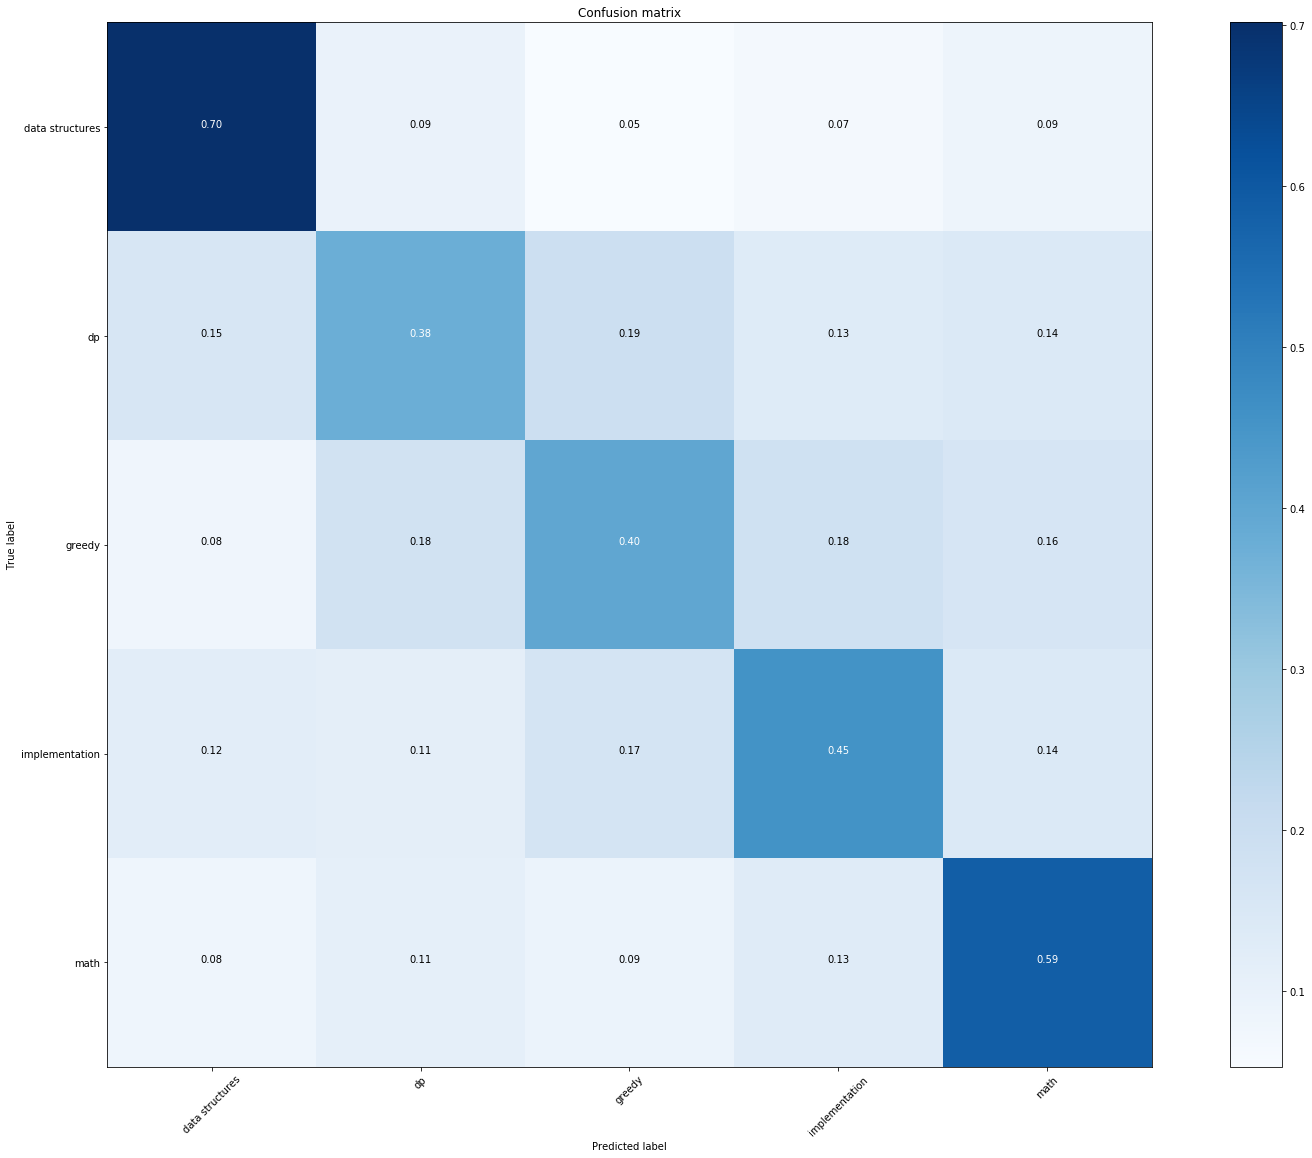

In [22]:
labels = ['data structures', 'dp', 'greedy', 'implementation', 'math']

print(classification_report(all_targs, all_preds, labels=labels))
print(accuracy_score(all_targs, all_preds))
print(f1_score(all_targs, all_preds, average='weighted'))
plot_confusion_matrix(all_targs, all_preds, labels)

### 10-class

In [8]:
trunner = TextRunner([None], top10s[0], top10s[1], 'top10s')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

Checkpoint reached: raw data cleaned.
multiclass classification.


In [22]:
print(in_dim)

7616


In [9]:
runs = 1
out_dim = 10

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        print(f'{j+1}-th Fold.')
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        textmlp = MWrapper(MLP(in_dim, out_dim),
                           f'{i}_10s_mlp_gpu_{j}')
        textmlp.model.apply(weights_init)

        dl_train = fd.DataLoader(SimpleBoWDataset(X_train, y_train, in_dim),
                                 batch_size=32, num_workers=2,
                                 pad_idx=1, transpose=False)
        dl_val = fd.DataLoader(SimpleBoWDataset(X_test, y_test, in_dim),
                               batch_size=32, num_workers=2,
                               pad_idx=1, transpose=False)
        modeldata = fs.ModelData(str(textmlp.path), dl_train, dl_val)
        learner = fl.Learner.from_model_data(textmlp.model,
                                             modeldata,
                                             opt_fn=Adam_lambda())
        learner.metrics = [fm.accuracy]
        learner.fit(5e-4, 100, best_save_name='best')
        
        dl_test = fd.DataLoader(SimpleBoWDataset(X_test, y_test, in_dim),
                                batch_size=32, num_workers=2,
                                pad_idx=1, transpose=False)
        learner.load('best')
        preds, targs = learner.predict_dl(dl_test)
        
        preds_txt.append(multi_to_text_out(preds, trunner.alldata.ovectorizer))
        targs_txt.append(multi_to_text_out(targs, trunner.alldata.ovectorizer))
        
        
        print(f1_score(np.concatenate(targs_txt), 
                       np.concatenate(preds_txt), average='micro'))

1-th Fold.


epoch      trn_loss   val_loss   accuracy                  
    0      0.180921   0.109237   0.318966  
    1      0.107652   0.097593   0.344828                  
    2      0.072293   0.099778   0.37069                    
    3      0.053791   0.103114   0.301724                   
    4      0.04462    0.110713   0.275862                   
    5      0.042329   0.104549   0.405172                   
    6      0.036943   0.102432   0.353448                   
    7      0.029769   0.103797   0.336207                   
    8      0.024764   0.091864   0.37931                    
    9      0.021774   0.095756   0.362069                   
    10     0.018233   0.093992   0.37931                    
    11     0.014642   0.1061     0.336207                   
    12     0.01267    0.09328    0.37931                    
    13     0.011784   0.091583   0.387931                   
    14     0.011558   0.098569   0.396552                   
    15     0.011426   0.09341    0.362069  

epoch      trn_loss   val_loss   accuracy                  
    0      0.154712   0.109384   0.310345  
    1      0.096197   0.100996   0.344828                  
    2      0.066655   0.116108   0.362069                   
    3      0.053847   0.104147   0.387931                   
    4      0.048836   0.116365   0.405172                   
    5      0.044007   0.091294   0.387931                   
    6      0.036428   0.100475   0.344828                   
    7      0.03222    0.093246   0.431034                   
    8      0.02491    0.093438   0.422414                   
    9      0.018931   0.090904   0.431034                   
    10     0.016151   0.088833   0.422414                   
    11     0.014647   0.096972   0.431034                   
    12     0.013479   0.094524   0.413793                   
    13     0.01209    0.091417   0.431034                   
    14     0.010776   0.096933   0.344828                   
    15     0.010097   0.099623   0.37069   

epoch      trn_loss   val_loss   accuracy                 
    0      0.193774   0.113566   0.301724  
    1      0.112459   0.100769   0.413793                  
    2      0.074879   0.103681   0.396552                   
    3      0.055446   0.110438   0.413793                   
    4      0.047688   0.159597   0.37931                    
    5      0.04958    0.10073    0.405172                  
    6      0.04318    0.094366   0.396552                  
    7      0.033886   0.092777   0.474138                   
    8      0.025994   0.095434   0.456897                   
    9      0.021746   0.091209   0.422414                   
    10     0.019703   0.100144   0.362069                   
    11     0.018245   0.092524   0.353448                   
    12     0.016134   0.093222   0.439655                   
    13     0.014194   0.094352   0.37069                    
    14     0.012561   0.100033   0.353448                   
    15     0.012299   0.10287    0.422414     

epoch      trn_loss   val_loss   accuracy                  
    0      0.185963   0.106981   0.275862  
    1      0.110683   0.097274   0.413793                  
    2      0.074651   0.101192   0.396552                   
    3      0.055905   0.139282   0.224138                   
    4      0.05511    0.101183   0.422414                  
    5      0.045707   0.095066   0.405172                   
    6      0.034433   0.099456   0.353448                  
    7      0.027702   0.100288   0.405172                   
    8      0.023974   0.106031   0.439655                   
    9      0.022283   0.0995     0.344828                   
    10     0.019362   0.095932   0.422414                   
    11     0.016201   0.095652   0.422414                   
    12     0.014706   0.094351   0.405172                   
    13     0.014929   0.098047   0.387931                   
    14     0.015476   0.111926   0.318966                   
    15     0.01638    0.102804   0.327586    

epoch      trn_loss   val_loss   accuracy                  
    0      0.205126   0.110726   0.275862  
    1      0.11671    0.100339   0.327586                  
    2      0.075086   0.101274   0.310345                   
    3      0.052523   0.106584   0.336207                   
    4      0.04413    0.110416   0.336207                   
    5      0.045407   0.118872   0.362069                   
    6      0.046149   0.09958    0.301724                   
    7      0.037085   0.093649   0.318966                   
    8      0.027734   0.092998   0.344828                   
    9      0.022185   0.102622   0.344828                   
    10     0.020263   0.109691   0.37069                    
    11     0.018887   0.090362   0.344828                   
    12     0.015894   0.092539   0.362069                   
    13     0.012224   0.098475   0.344828                   
    14     0.010093   0.100948   0.362069                   
    15     0.010438   0.09717    0.362069  

epoch      trn_loss   val_loss   accuracy                  
    0      0.176891   0.109906   0.327586  
    1      0.106986   0.092187   0.387931                  
    2      0.071982   0.093269   0.439655                   
    3      0.053719   0.121429   0.439655                   
    4      0.048709   0.109133   0.439655                   
    5      0.045929   0.086172   0.37931                    
    6      0.036774   0.085023   0.431034                   
    7      0.026709   0.086457   0.474138                   
    8      0.020429   0.091491   0.465517                   
    9      0.018925   0.092214   0.396552                   
    10     0.018936   0.086685   0.482759                   
    11     0.015856   0.088597   0.508621                   
    12     0.013404   0.096906   0.474138                   
    13     0.013763   0.089967   0.482759                   
    14     0.013513   0.097408   0.439655                    
    15     0.012068   0.093397   0.474138 

epoch      trn_loss   val_loss   accuracy                  
    0      0.197817   0.119684   0.258621  
    1      0.117069   0.107508   0.353448                  
    2      0.07859    0.112201   0.353448                   
    3      0.058885   0.123659   0.37069                    
    4      0.050155   0.120444   0.353448                   
    5      0.042139   0.110413   0.37069                    
    6      0.036199   0.107251   0.37069                    
    7      0.031703   0.1097     0.353448                   
    8      0.027189   0.115057   0.396552                   
    9      0.023561   0.102556   0.387931                   
    10     0.019148   0.111744   0.293103                   
    11     0.015967   0.114391   0.387931                   
    12     0.014459   0.112814   0.37931                    
    13     0.014033   0.10479    0.353448                   
    14     0.014106   0.105561   0.318966                   
    15     0.013898   0.110765   0.336207  

KeyboardInterrupt: 

In [24]:
all_preds = np.concatenate(preds_txt)
all_targs = np.concatenate(targs_txt)

In [10]:
# pickle.dump([all_preds, all_targs], open('data/results/mlp-gpu_10s.pkl', 'wb'))
all_preds, all_targs = pickle.load(open('data/results/mlp-gpu_10s.pkl', 'rb'))

In [11]:
print(all_preds[7])

dfs and similar


                         precision    recall  f1-score   support

            brute force       0.15      0.03      0.05        65
constructive algorithms       0.33      0.19      0.24        64
        data structures       0.56      0.59      0.57       110
                     dp       0.45      0.33      0.38       144
        dfs and similar       0.44      0.19      0.27        36
               geometry       0.62      0.61      0.62        49
                 greedy       0.36      0.26      0.31       121
         implementation       0.52      0.81      0.63       405
                   math       0.44      0.29      0.35       132
                strings       0.56      0.30      0.39        33

            avg / total       0.46      0.49      0.46      1159

0.49352890422778256
0.4564429853069325
Normalized confusion matrix
[[0.03077 0.      0.09231 0.07692 0.      0.01538 0.10769 0.63077 0.04615 0.     ]
 [0.      0.1875  0.09375 0.07812 0.04688 0.03125 0.07812 0.40625 0

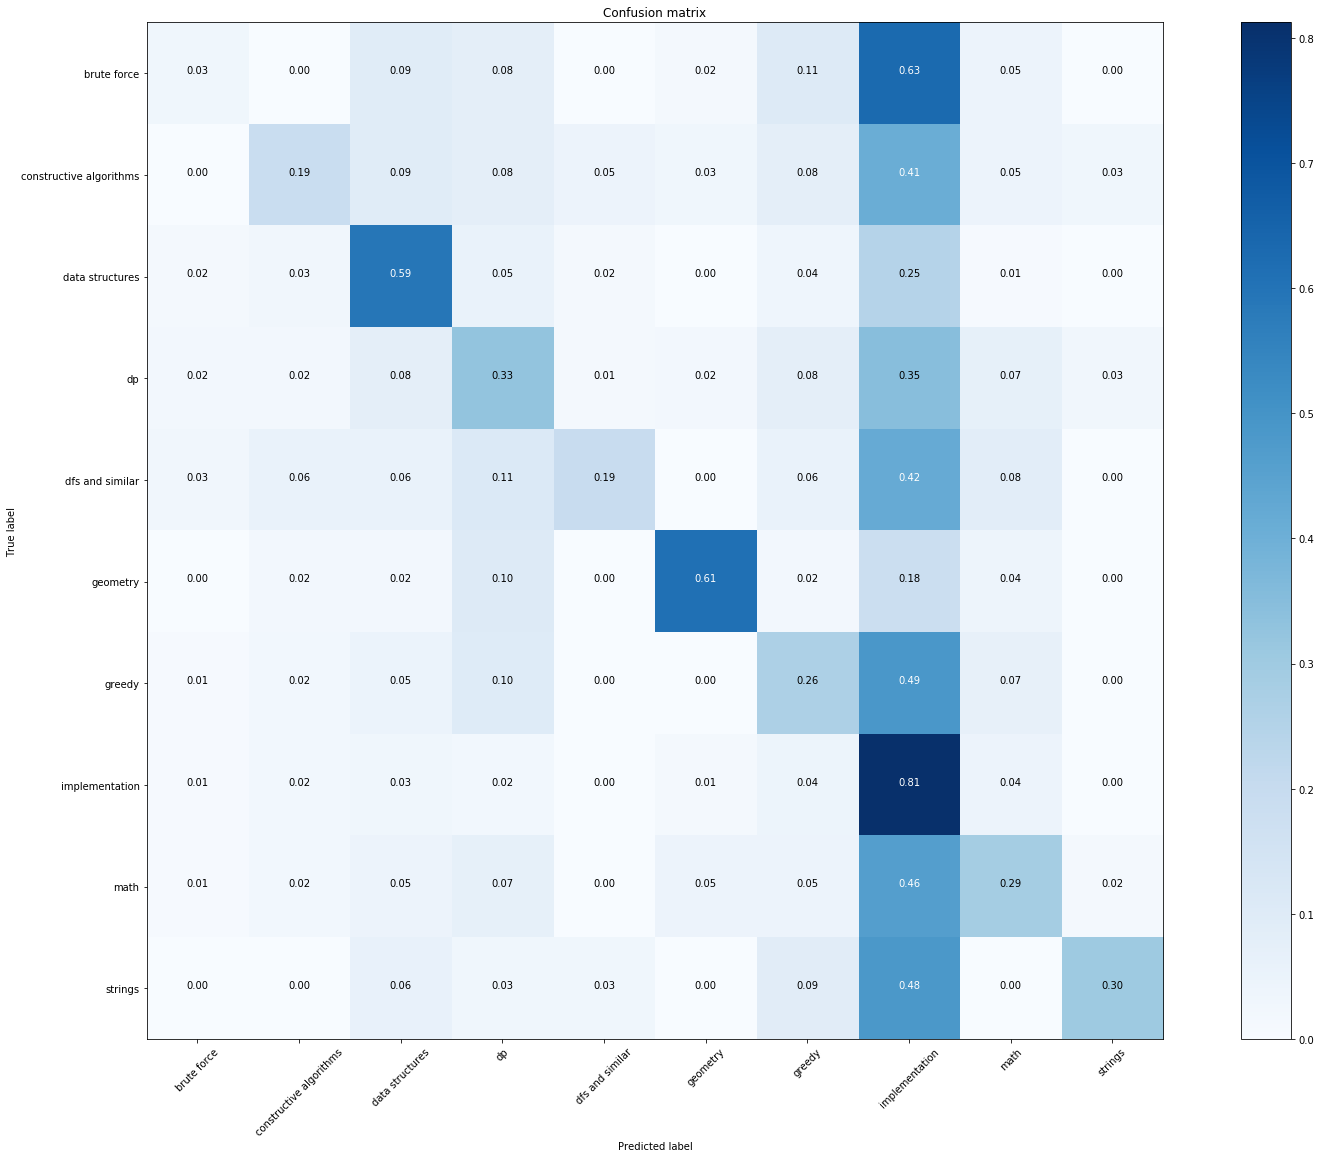

In [12]:
labels = ['brute force', 'constructive algorithms', 'data structures',
          'dp', 'dfs and similar', 'geometry', 'greedy',
          'implementation', 'math', 'strings']

print(classification_report(all_targs, all_preds, labels=labels))
print(accuracy_score(all_targs, all_preds))
print(f1_score(all_targs, all_preds, average='weighted'))
plot_confusion_matrix(all_targs, all_preds, labels)